## 8-TestModels_OneCluster
This script:
- Reads in the dataframe containing the per-LSOA summary info (e.g. mean/max/min embedding, mean/max/min embedding per cluster grouping, % of images in each cluster in each LSOA)
- Compares model performance:
    - using data only from one of the clusters, for each of the clusters

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor

data_dir = os.path.join("../../../../data/embeddings/")
imd_file = os.path.join("../../../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

def evaluate_imd_model(y_true, y_pred, column,num_in_class, num_lsoas, plot=True, plot_collectively = False, ax=False ):

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    #print("Model evaluation metrics:")
    #for k, v in metrics.items():
    #    print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel(f"True {column}")
        plt.ylabel(f"Predicted {column}")
        plt.title(f"{column}")
        plt.grid(True)
        plt.show()

    # Scatter plot
    if plot_collectively:
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}: \n{num_in_class} images\n {num_lsoas} LSOAs", fontsize=15)
        ax.grid(True)
        ax.text(
            0.01, 0.99,  # x=1% from left, y=99% from bottom
            f'R² = {r2:.2f}, RMSE = {rmse:.0f}',
            transform=ax.transAxes,  # use axes coordinates
            fontsize=12,
            verticalalignment='top',  # anchor to top so it doesn’t go outside
            horizontalalignment='left')
    
    return metrics

### Get imd data

In [2]:
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

### Get embedding data

In [13]:
file_ending = 'kmeanscluster7' # 'planninguseclasses' # 'refined_again'

k = 7

In [4]:
big_summary_df = pd.read_pickle(data_dir +f"embedding_summaries/big_summary_df_{file_ending}.pkl")
big_summary_df_with_imd = pd.merge(left=big_summary_df, right=imd, on="LSOA21CD")
big_summary_df_with_imd['imd_rerank'] = big_summary_df_with_imd['imd_rank'].rank(method='first').astype(int)

In [14]:
big_summary_df

,LSOA21CD,1_mean,6_mean,5_mean,7_mean,3_mean,4_mean,2_mean,overall_mean,1_max,...,count_5,count_6,count_7,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_7
0,E01004766,"[0.033103533, -0.07074865, -0.0038302832, -0.0...","[0.03522002, -0.053018257, 0.013809818, -0.003...","[0.023067513, -0.051904604, 0.005900901, -0.01...","[0.06578761, -0.07596135, -0.018992858, 0.0056...","[0.034151368, -0.04616829, -0.01352316, -0.010...","[0.022992719, -0.064196885, 0.017334871, -0.00...","[0.04612167, -0.063937575, -0.0060228854, -0.0...","[0.034810767, -0.058544807, 0.0016876708, -0.0...","[0.046476994, -0.042404536, 0.011767318, 0.004...",...,8.0,11.0,1.0,7.812500,28.125000,15.625000,17.187500,12.500000,17.187500,1.562500
1,E01004767,"[0.0155904, -0.06697523, -0.008416992, 0.00601...","[0.036190536, -0.041433036, 0.01250577, -0.011...","[0.03722277, -0.05215759, -0.011467544, -0.018...","[0.031461813, -0.06416202, -0.025430348, 0.007...","[0.022189489, -0.058764618, -0.016952509, 0.00...","[0.026041085, -0.06665549, 0.013026682, -0.007...","[0.042382684, -0.06791675, -0.0048367633, -0.0...","[0.03144143, -0.05888115, -0.0012278779, -0.00...","[0.0440901, -0.03508209, 0.007759808, 0.041439...",...,7.0,17.0,5.0,15.277778,20.833333,6.944444,16.666667,9.722222,23.611111,6.944444
2,E01004768,"[0.037889328, -0.081487596, -0.0024430014, 0.0...","[0.0106770545, -0.05135075, 0.022684604, -0.01...",NaN,"[0.053052247, -0.0632091, -0.014393783, 0.0062...","[0.035934847, -0.047909573, -0.008653186, -0.0...","[0.033699464, -0.062361263, 0.012203996, -0.01...","[0.038975507, -0.065425605, -0.002837063, -0.0...","[0.039971534, -0.063287765, -0.0003090683, -0....","[0.06717749, -0.04954933, 0.009416995, 0.03412...",...,0.0,1.0,12.0,6.818182,20.454545,6.818182,36.363636,0.000000,2.272727,27.272727
3,E01004769,"[0.037865788, -0.0547471, -0.015366654, -0.006...","[0.061572693, -0.05962702, 0.012585461, -0.015...","[0.044616487, -0.06895213, -0.009721331, 0.008...","[0.047364842, -0.052075706, -0.026688226, -0.0...","[0.05049605, -0.06860547, -0.01464322, -0.0088...","[0.034732457, -0.06680633, 0.0067776283, -0.01...","[0.023240106, -0.06275923, -0.011262887, -0.00...","[0.038645875, -0.059855007, -0.010084866, -0.0...","[0.055508982, -0.026112689, 0.00014157066, 0.0...",...,1.0,2.0,9.0,22.500000,17.500000,5.000000,25.000000,2.500000,5.000000,22.500000
4,E01004770,"[0.019877654, -0.047637712, -0.00015878165, 0....","[0.034624744, -0.035400465, 0.017509863, -0.01...",NaN,"[0.024157813, -0.06713715, -0.01565353, 0.0050...","[0.025436353, -0.053490806, -0.017503206, -0.0...","[0.030130852, -0.06452417, 0.004716233, -0.010...","[0.047155026, -0.053241987, -0.013663166, -0.0...","[0.03305047, -0.057412803, -0.0049337186, -0.0...","[0.040416043, -0.021657884, 0.014084354, 0.012...",...,0.0,2.0,6.0,12.500000,30.000000,5.000000,32.500000,0.000000,5.000000,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,E01005901,NaN,NaN,NaN,NaN,NaN,"[0.02158466, -0.06535083, 0.002541018, -0.0120...","[0.027051007, -0.056315992, -0.009303177, -0.0...","[0.024317836, -0.06083342, -0.0033810788, -0.0...",NaN,...,0.0,0.0,0.0,0.000000,50.000000,0.000000,50.000000,0.000000,0.000000,0.000000
1691,E01005939,NaN,NaN,NaN,NaN,NaN,"[0.024516538, -0.060917716, 0.010709342, -0.02...","[0.031052334, -0.053518843, -0.008302648, -0.0...","[0.027784435, -0.057218272, 0.0012033462, -0.0...",NaN,...,0.0,0.0,0.0,0.000000,50.000000,0.000000,50.000000,0.000000,0.000000,0.000000
1692,E01005980,NaN,NaN,NaN,NaN,NaN,"[0.025245028, -0.059243917, 0.006049343, -0.01...","[0.032022417, -0.054652877, 0.007733837, -0.02...","[0.028633721, -0.0569484, 0.0068915905, -0.019...",NaN,...,0.0,0.0,0.0,0.000000,50.000000,0.000000,50.000000,0.000000,0.000000,0.000000
1693,E01006287,NaN,NaN,NaN,NaN,NaN,"[0.014723813, -0.06370592, 0.019477382, 0.0004...","[0.016617486, -0.058633998, -0.0058315084, -0....","[0.01567065, -0.06116996, 0.0068229362, -0.001...",NaN,...,0.0,0.0,0.0,0.0

# Testing performance using images from just one cluster

Test the performance of a random forest model with a 80-20% train-test split.  
Test performance using just images from one category. Test this for each of the different categories and compare performance.

In [5]:
def is_missing_embedding(x):
    return isinstance(x, float) and np.isnan(x)

1, 1282
2, 1628
3, 1558
4, 1618
5, 1232
6, 1537
7, 916


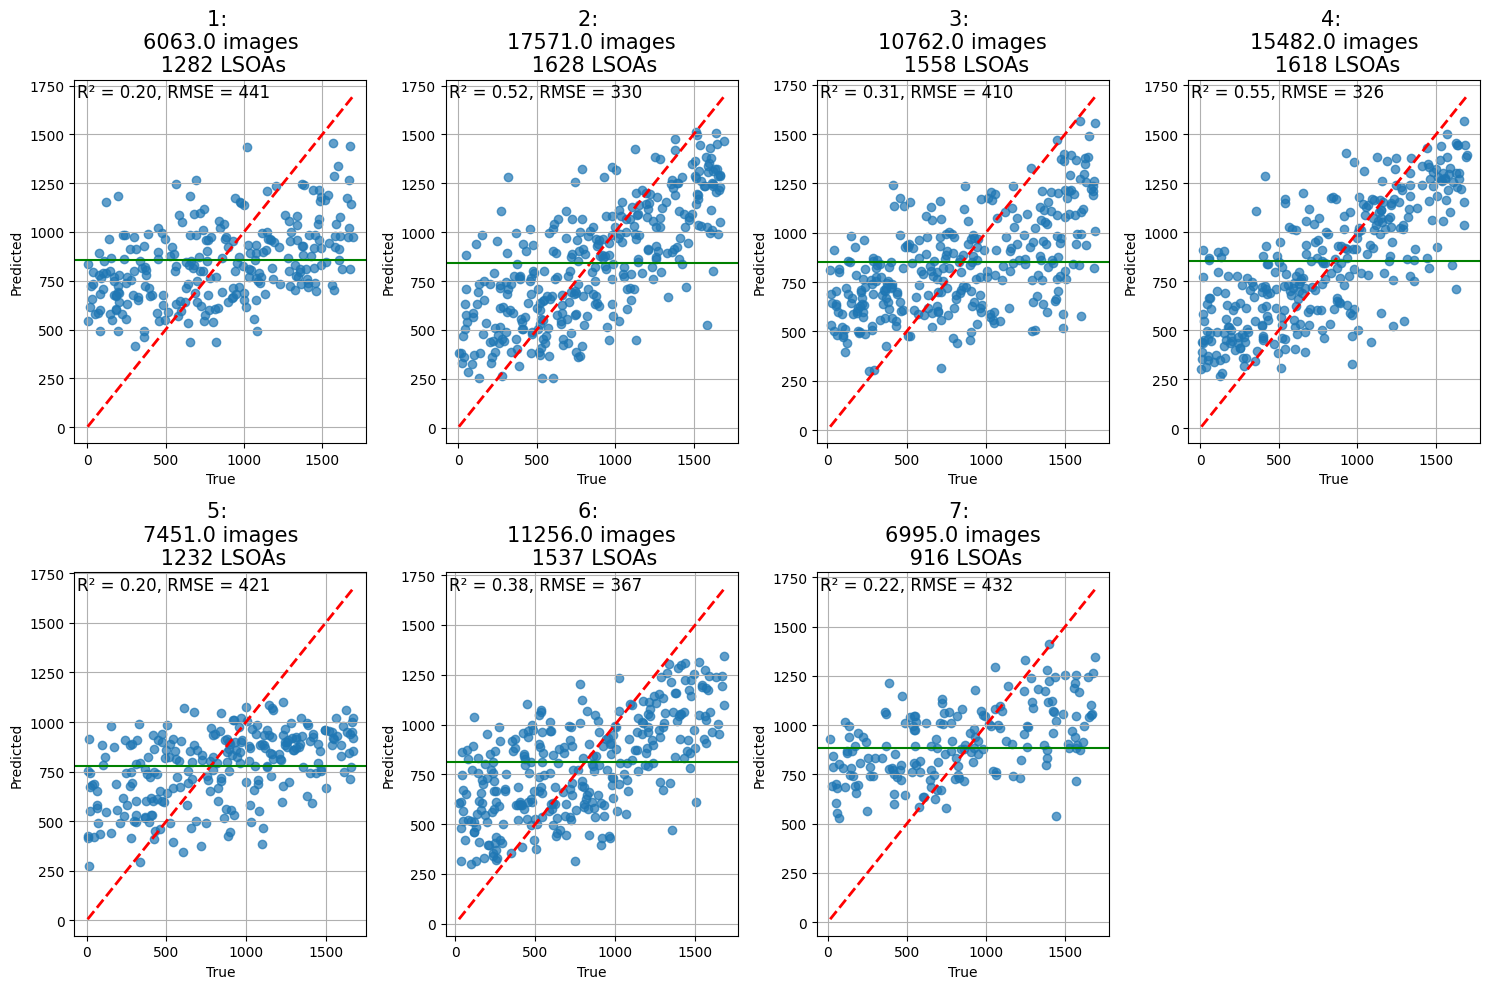

In [6]:
fig, axs=plt.subplots(ncols=4, nrows=2, figsize=(15,10))
axs=axs.flatten()
i=0
for cluser_num in range(2,k+1) :
    column = f'{col_name}_mean'
    column_two = f'count_{col_name}'
    one_image_type = big_summary_df_with_imd[["LSOA21CD", column, column_two, "imd_rerank"]].copy()
    num_in_class = one_image_type[column_two].sum()
    # Missing indicator
    one_image_type["missing"] = one_image_type[column].apply(is_missing_embedding).astype(int)

    # Replace missing scalar 0 with a 512-dim zero vector
    #one_image_type[column] = one_image_type[column].apply(
    #    lambda x: np.zeros(512) if is_missing_embedding(x) else x)

    one_image_type = one_image_type.sort_values("LSOA21CD").reset_index(drop=True)

    # Get rid of LSOAs with missing embeddings
    one_image_type = one_image_type[one_image_type['missing']==0]
    print(f"{col_name}, {len(one_image_type)}")
    num_lsoas = len(one_image_type)    
    
    # Get response and predictor variables 
    X_emb = np.stack(one_image_type[column].values)  
    X_missing = one_image_type[["missing"]].values        
    X = np.hstack([X_emb, X_missing])
    
    y = one_image_type["imd_rerank"].values

    # Train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Fit a model (Random Forest Regressor example)
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)

    # Usage example:
    metrics = evaluate_imd_model(y_test, y_pred, col_name, num_in_class, num_lsoas, plot=False, plot_collectively =True, ax=axs[i])
    axs[i].axhline(y=one_image_type['imd_rerank'].mean(), color='green', linestyle='-')
        
    
    i=i+1
    
for j in range(i, len(axs)):
    axs[j].axis("off")

    fig.tight_layout()

## Sample the images in each cluster

In [10]:
import pickle
points_data_cache = data_dir + f"embedding_summaries/expanded_gdf_withclustering.pkl"
with open(points_data_cache, "rb") as f:
    expanded_gdf = pickle.load(f)
    
expanded_gdf

,point_id,latitude,longitude,date,image_files,embedding,category_scores,geometry,LSOA21CD,LSOA21NM,...,GlobalID,scene_cluster_2,scene_cluster_3,scene_cluster_4,scene_cluster_5,scene_cluster_6,scene_cluster_7,scene_cluster_8,scene_cluster_9,scene_cluster_10
0,0,53.457824,-2.225911,2025-03,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.023960814, -0.05716481, -0.033669192, -0.00...","[0.24731578, 0.25831506, 0.2469949, 0.24737424]",POINT (-2.225911 53.457824),E01005284,Manchester 026C,...,e00eadf6-8e6f-4526-bad4-e7cb06d3a61f,1,1,1,1,1,1,1,9,9
1,0,53.457824,-2.225911,2025-03,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.045469392, -0.06291092, -0.010693804, -0.01...","[0.25888473, 0.24810642, 0.24715543, 0.24585338]",POINT (-2.225911 53.457824),E01005284,Manchester 026C,...,e00eadf6-8e6f-4526-bad4-e7cb06d3a61f,2,2,4,4,6,6,2,2,5
2,0,53.457824,-2.225911,2025-03,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.04943561, -0.053400014, -0.0005624877, -0.0...","[0.2580101, 0.24558753, 0.24855082, 0.24785157]",POINT (-2.225911 53.457824),E01005284,Manchester 026C,...,e00eadf6-8e6f-4526-bad4-e7cb06d3a61f,2,2,4,4,6,6,5,5,5
3,0,53.457824,-2.225911,2025-03,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.056650903, -0.069001906, 0.01618063, -0.009...","[0.24965681, 0.25334936, 0.25103512, 0.24595869]",POINT (-2.225911 53.457824),E01005284,Manchester 026C,...,e00eadf6-8e6f-4526-bad4-e7cb06d3a61f,2,2,1,5,5,5,4,1,1
4,1,53.457141,-2.049611,2025-06,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.012461452, -0.061494295, -0.04214132, 0.031...","[0.25074413, 0.2525265, 0.24680887, 0.24992046]",POINT (-2.049611 53.457141),E01006024,Tameside 022A,...,d80e5056-8d39-4cf3-88eb-9d72ea0414be,1,1,3,3,3,7,8,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75575,19194,53.582965,-2.406821,2024-05,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.07109462, -0.053741224, 0.0013528138, 0.000...","[0.26122782, 0.24504152, 0.24691361, 0.24681711]",POINT (-2.406821 53.582965),E01004931,Bolton 017E,...,8c0fa890-ae8d-45a7-802e-693e225c4ab7,2,2,4,4,6,6,5,5,5
75576,19195,53.389012,-2.284530,2025-05,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.039534137, -0.070287, -0.004217098, -0.0161...","[0.25736764, 0.246737, 0.24894291, 0.24695249]",POINT (-2.28453 53.389012),E01005070,Manchester 051B,...,21a49064-0bd5-48cc-ae6b-c4606fd36959,1,1,1,1,1,1,1,9,9
75577,19195,53.389012,-2.284530,2025-05,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.008305122, 0.0006316668, -0.0077241044, 0.0...","[0.24538274, 0.2471006, 0.25511703, 0.2523996]",POINT (-2.28453 53.389012),E01005070,Manchester 051B,...,21a49064-0bd5-48cc-ae6b-c4606fd36959,1,1,1,1,1,5,1,9,9
75578,19195,53.389012,-2.284530,2025-05,/nfs/a319/gy17m2a/INTEGRATE/llm/data/embedding...,"[0.019639634, -0.08036961, -0.022852229, -0.00...","[0.2579031, 0.24620004, 0.24676225, 0.24913457]",POINT (-2.28453 53.389012),E01005070,Manchester 051B,...,21a49064-0bd5-48cc-ae6b-c4606fd36959,2,3,2,2,2,3,7,7,2
